# Function 2

## Function Description
Imagine a black box, or a mystery ML model, that takes two numbers as input and returns a log-likelihood score. Your goal
is to maximise that score, but each output is noisy, and depending on where you start, you might get stuck in a local optimum. 

To tackle this, you use Bayesian optimisation, which selects the next inputs based on what it has learned so far. It 
balances exploration with exploitation, making it well suited to noisy outputs and complex functions with many local peaks.

## Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern, WhiteKernel

## Data

In [6]:
# --- Step 1: Initialise dataset for Function 2 ---
df_init = pd.DataFrame({
    "x1": [0.66579958, 0.877790989, 0.142699074, 0.845275429, 0.454647141,
           0.577712844, 0.438166062, 0.341749593, 0.338648157, 0.702636557],
    "x2": [0.123969128, 0.778627501, 0.349005131, 0.711120267, 0.29045518,
           0.771973184, 0.685018257, 0.02869772, 0.213867246, 0.926564198],
    "y":  [0.538996119, 0.42058624, -0.065623624, 0.293992912, 0.21496451,
           0.02310555, 0.244619344, 0.038749015, -0.013857618, 0.611205216]
})

# --- Step 2: Weekly added data ---
new_data = [
    (0.731544, 0.000000, 0.489952847634612),  # week 1
    (0.969849, 0.919598, -0.153997988797225),  # week 2
    (0.698492, 0.396985, 0.555582965915397),  # week 3
    (0.753769, 1.000000, 0.192830487831688),  # week 4
    (0.663317, 1.000000, 0.360005035214089),  # week 5
    (0.000000, 1.000000, 0.0440486189280713),  # week 6
    (0.718593, 0.718593, 0.560721640141879),  # week 7
    (0.683417, 0.000000, 0.653775106173301),  # week 8
    (0.698492, 0.000000, 0.571054108936695),  # week 9
    (0.698492, 0.080000, 0.557010661532846),  # week 10
    (0.678392, 0.000000, 0.48700590982128),  # week 11
    (0.698492, 0.688442, 0.465566008601158),  # week 12
    (0.683417, 0.000000, 0.549499435028279),  # week 13
]
df_new = pd.DataFrame(new_data, columns=["x1", "x2", "y"])
df_all = pd.concat([df_init, df_new], ignore_index=True)

# --- Step 3: Convert to NumPy arrays for modelling ---
X_check = df_all[["x1", "x2"]].values   # shape (10, 2)
y_check = df_all["y"].values.reshape(-1, 1)   # shape (10, 1)

# --- Step 4: Quick verification ---
print("Dataset shape:", X_check.shape, y_check.shape)
print(df_all)

# --- Step 5: Clean versions for further use ---
X_init = df_all[["x1", "x2"]].to_numpy()
y_raw = df_all["y"].to_numpy()

Dataset shape: (23, 2) (23, 1)
          x1        x2         y
0   0.665800  0.123969  0.538996
1   0.877791  0.778628  0.420586
2   0.142699  0.349005 -0.065624
3   0.845275  0.711120  0.293993
4   0.454647  0.290455  0.214965
5   0.577713  0.771973  0.023106
6   0.438166  0.685018  0.244619
7   0.341750  0.028698  0.038749
8   0.338648  0.213867 -0.013858
9   0.702637  0.926564  0.611205
10  0.731544  0.000000  0.489953
11  0.969849  0.919598 -0.153998
12  0.698492  0.396985  0.555583
13  0.753769  1.000000  0.192830
14  0.663317  1.000000  0.360005
15  0.000000  1.000000  0.044049
16  0.718593  0.718593  0.560722
17  0.683417  0.000000  0.653775
18  0.698492  0.000000  0.571054
19  0.698492  0.080000  0.557011
20  0.678392  0.000000  0.487006
21  0.698492  0.688442  0.465566
22  0.683417  0.000000  0.549499


## Optimisation Model

In [7]:
# 1) Prepare training arrays (ensure shapes are correct)
X_train = X_init.astype(float)                 # shape (n, 2)
y_train = y_raw.astype(float).ravel()          # shape (n,)

# --- Adjustable parameters ---
nu = 2.5
grid_n = 200  # keep simple & light; change to 150/200 if you want finer resolution
beta = 1.0  # "high k"; feel free to try 4.0 or 5.0 in early weeks
random_state = 42

# 2) Define GP kernel: Constant * Matern(ν=2.5, "higher ν") + WhiteKernel (noise)
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.2, 0.2], # change 0.3 to 0.2
                                      length_scale_bounds=(1e-2, 1.0), # change upper bound 1e2 to 1.0
                                      nu=nu) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e-1)) # change noise bound 1e1->1e-1

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.0,               # noise is modeled by WhiteKernel
    normalize_y=True,
    n_restarts_optimizer=5,
    random_state=random_state
)

gp.fit(X_train, y_train)

# 3) Build a grid over [0, 1] x [0, 1] to evaluate acquisition
x1_lin = np.linspace(0.0, 1.0, grid_n)
x2_lin = np.linspace(0.0, 1.0, grid_n)
X1g, X2g = np.meshgrid(x1_lin, x2_lin)
X_grid = np.column_stack([X1g.ravel(), X2g.ravel()])

# 4) Predict posterior mean & std on the grid
mu, std = gp.predict(X_grid, return_std=True)

# 5) UCB acquisition (high beta for more exploration)
acq = mu + beta * std

# 6) Pick top-5 query candidates (avoid exact duplicates)
top_idxs = np.argsort(-acq)[:200]  # take a larger slice first
top_points = []
seen = set()
for idx in top_idxs:
    x1, x2 = X_grid[idx]
    key = (round(float(x1), 5), round(float(x2), 5))
    if key not in seen:
        seen.add(key)
        top_points.append((float(x1), float(x2), float(acq[idx]), float(mu[idx]), float(std[idx])))
    if len(top_points) == 5:
        break

# 7) Print recommendations
print("\nTop-5 UCB candidates (x1, x2, UCB, mean, std):")
for i, (x1, x2, ucb, m, s) in enumerate(top_points, 1):
    print(f"{i}. ({x1:.4f}, {x2:.4f})  UCB={ucb:.6f}  mean={m:.6f}  std={s:.6f}")

best_x1, best_x2, *_ = top_points[0]
print(f"\nRecommended next query (UCB argmax): x1={best_x1:.6f}, x2={best_x2:.6f}")


Top-5 UCB candidates (x1, x2, UCB, mean, std):
1. (0.6985, 0.0000)  UCB=0.639802  mean=0.569515  std=0.070287
2. (0.6935, 0.0000)  UCB=0.639620  mean=0.571153  std=0.068467
3. (0.6985, 0.0050)  UCB=0.639601  mean=0.569479  std=0.070122
4. (0.6985, 0.0101)  UCB=0.639404  mean=0.569435  std=0.069969
5. (0.6935, 0.0050)  UCB=0.639401  mean=0.571070  std=0.068330

Recommended next query (UCB argmax): x1=0.698492, x2=0.000000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


## Visualisation
### Part 1: Plot 2D heatmap of acquisition

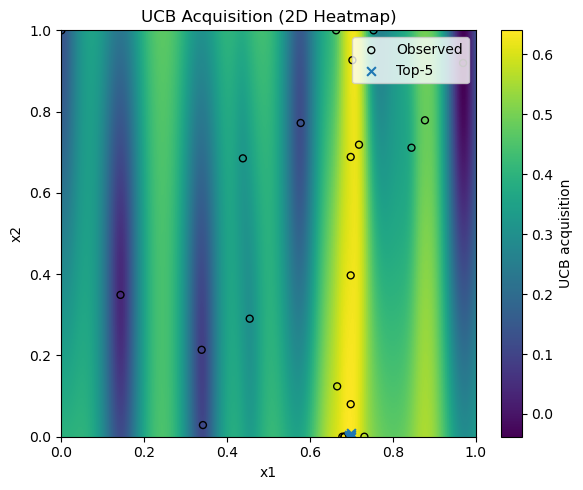

In [8]:
A = acq.reshape(grid_n, grid_n)
plt.figure(figsize=(6, 5))
plt.imshow(A, extent=[0, 1, 0, 1], origin="lower", aspect="auto")
plt.colorbar(label="UCB acquisition")
plt.scatter(X_train[:, 0], X_train[:, 1], s=25, edgecolor="k", facecolor="none", label="Observed")
plt.scatter([p[0] for p in top_points], [p[1] for p in top_points], s=40, marker="x", label="Top-5")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("UCB Acquisition (2D Heatmap)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

### Part 2: Plot 3D surface of acquisition

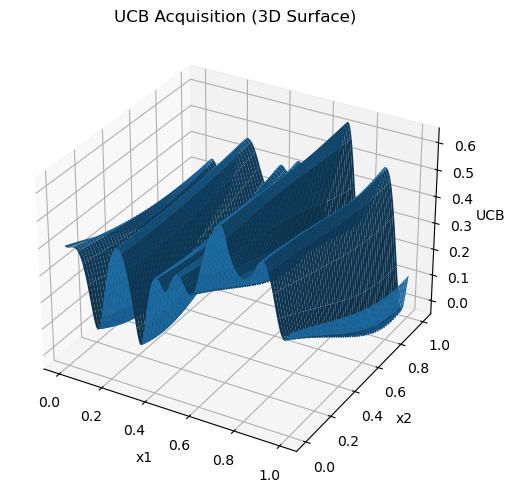

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X1g, X2g, A, linewidth=0, antialiased=True)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("UCB")
ax.set_title("UCB Acquisition (3D Surface)")
plt.tight_layout()
plt.show()